# RM 294 - Optimization I
## Project 2
### Archie Don, Jake Embleton, Gabriel Kinshuk, Vinay Sangamalli

---

In [85]:
import pandas as pd
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Changeable parameters

In [58]:
csv1 = "roi_company1.csv"
csv2 = "roi_company2.csv"
csv3 = "roi_monthly.csv"

budget = 10

## Linear program formulation

In [59]:
roi_company1 = pd.read_csv(csv1)
roi_company1['UpperBound'] = roi_company1['UpperBound'].replace('inf', np.inf).astype(float)
roi_company1['LowerBound'] = roi_company1['LowerBound'].astype(float)

In [60]:
def solve_lp_model(roi_df, budget, use_platform_cap=True, platform_cap=3.0, verbose=True):
    """
    Solve LP model for marketing budget allocation
    
    Parameters:
    -----------
    roi_df : DataFrame
        ROI data with columns: Platform, Tier, LowerBound, UpperBound, ROI
    budget : float
        Total budget available
    use_platform_cap : bool, default=True
        Whether to enforce the per-platform investment cap
    platform_cap : float, default=3.0
        Maximum investment per platform (in millions)
    verbose : bool, default=True
        Whether to print the solution
    
    Returns:
    --------
    dict with keys: 'model', 'x', 'platforms', 'tiers', 'obj_val', 'status'
    """
    BIGM = budget
    
    # Extract data
    n = len(roi_df)
    platforms = roi_df['Platform'].to_numpy()
    tiers = roi_df['Tier'].to_numpy()
    
    # Convert bounds to per-tier amounts
    LB = np.zeros(n)
    UB = roi_df['UpperBound'].replace(np.inf, BIGM).to_numpy() - roi_df['LowerBound'].to_numpy()
    ROI = roi_df['ROI'].to_numpy()
    
    # Create model
    mod = gp.Model()
    x = mod.addMVar(n, lb=LB, ub=UB)
    
    # Objective
    mod.setObjective(gp.quicksum(ROI[i] * x[i] for i in range(n)), sense=gp.GRB.MAXIMIZE)
    
    # Constraints
    # Total budget
    mod.addConstr(gp.quicksum(x[i] for i in range(n)) <= budget)
    
    # Print + TV <= Facebook + Email
    mod.addConstr(
        gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Print', 'TV']) <=
        gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Facebook', 'Email'])
    )
    
    # Social media >= 2 × (SEO + AdWords)
    mod.addConstr(
        gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter'])
        >= 2 * gp.quicksum(x[i] for i in range(n) if platforms[i] in ['SEO', 'AdWords'])
    )
    
    # Max per platform (optional)
    if use_platform_cap:
        for p in np.unique(platforms):
            mod.addConstr(gp.quicksum(x[i] for i in range(n) if platforms[i] == p) <= platform_cap)
    
    # Solve
    mod.Params.OutputFlag = 0
    mod.optimize()
    
    # Display
    if verbose and mod.status == gp.GRB.OPTIMAL:
        for i in range(n):
            if x.X[i] > 1e-6:
                print(f"{platforms[i]:10s} Tier {int(tiers[i])}: {x.X[i]:6.3f}")
        print(f"\nTotal ROI = {mod.objVal:.4f}")
    
    return {
        'model': mod,
        'x': x.X if mod.status == gp.GRB.OPTIMAL else None,
        'platforms': platforms,
        'tiers': tiers,
        'obj_val': mod.objVal if mod.status == gp.GRB.OPTIMAL else None,
        'status': mod.status
    }

In [93]:
linear_program_solution = solve_lp_model(roi_company1, budget=10, use_platform_cap=True)

TV         Tier 1:  3.000
AdWords    Tier 1:  1.000
Instagram  Tier 1:  2.900
Instagram  Tier 2:  0.100
Email      Tier 1:  3.000

Total ROI = 0.5436


---

## Mixed integer formulation

In [62]:
roi_company2 = pd.read_csv(csv2)
roi_company2['UpperBound'] = roi_company2['UpperBound'].replace('inf', np.inf).astype(float)
roi_company2['LowerBound'] = roi_company2['LowerBound'].astype(float)

In [63]:
def solve_mip_model(roi_df, budget, use_platform_cap=True, platform_cap=3.0, verbose=True):
    """
    Solve MIP model for marketing budget allocation with sequential tier ordering
    
    Parameters:
    -----------
    roi_df : DataFrame
        ROI data with columns: Platform, Tier, LowerBound, UpperBound, ROI
    budget : float
        Total budget available
    use_platform_cap : bool, default=True
        Whether to enforce the per-platform investment cap
    platform_cap : float, default=3.0
        Maximum investment per platform (in millions)
    verbose : bool, default=True
        Whether to print the solution
    
    Returns:
    --------
    dict with keys: 'model', 'x', 'y', 'platforms', 'tiers', 'obj_val', 'status'
    """
    BIGM = budget
    
    # Get data
    n = len(roi_df)
    platforms = roi_df['Platform'].to_numpy()
    tiers = roi_df['Tier'].to_numpy()
    
    # Convert cumulative bounds to incremental
    LB = np.zeros(n)
    UB = roi_df['UpperBound'].replace(np.inf, BIGM).to_numpy() - roi_df['LowerBound'].to_numpy()
    UB = np.maximum(UB, 0.0)
    
    mip_ROI = roi_df['ROI'].to_numpy()
    
    # Create model
    mip_mod = gp.Model()
    
    # Continuous investment vars
    mip_x = mip_mod.addMVar(n, lb=0.0, ub=UB)
    
    # Binary activation vars
    y = mip_mod.addMVar(n, vtype='B')
    
    # === Objective ===
    mip_mod.setObjective(gp.quicksum(mip_ROI[i] * mip_x[i] for i in range(n)), sense=gp.GRB.MAXIMIZE)
    
    # === Constraints ===
    
    # Big-M linking (only upper bound, since per-tier LB=0)
    mip_mod.addConstrs((mip_x[i] <= UB[i] * y[i] for i in range(n)))
    
    # Sequential tier ordering
    for p in np.unique(platforms):
        idxs = np.where(platforms == p)[0]
        idxs = idxs[np.argsort(tiers[idxs])]
        for i1, i2 in zip(idxs[:-1], idxs[1:]):
            mip_mod.addConstr(y[i2] <= y[i1])
            mip_mod.addConstr(mip_x[i1] >= UB[i1] * y[i2])
    
    # Total budget
    mip_mod.addConstr(gp.quicksum(mip_x[i] for i in range(n)) <= budget)
    
    # Print + TV <= Facebook + Email
    mip_mod.addConstr(
        gp.quicksum(mip_x[i] for i in range(n) if platforms[i] in ['Print', 'TV']) <=
        gp.quicksum(mip_x[i] for i in range(n) if platforms[i] in ['Facebook', 'Email'])
    )
    
    # Social media >= 2 * (SEO + AdWords)
    mip_mod.addConstr(
        gp.quicksum(mip_x[i] for i in range(n) if platforms[i] in ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter'])
        >= 2 * gp.quicksum(mip_x[i] for i in range(n) if platforms[i] in ['SEO', 'AdWords'])
    )
    
    # Max 3 mil per platform
    if use_platform_cap:
        for p in np.unique(platforms):
            mip_mod.addConstr(gp.quicksum(mip_x[i] for i in range(n) if platforms[i] == p) <= platform_cap)
    
    # === Solve ===
    mip_mod.Params.OutputFlag = 0
    mip_mod.optimize()
    
    # === Display ===
    if verbose and mip_mod.status == gp.GRB.OPTIMAL:
        for i in range(n):
            if mip_x.X[i] > 1e-6:
                print(f"{platforms[i]:10s} Tier {int(tiers[i])}: {mip_x.X[i]:6.3f}")
        print(f"\nTotal ROI = {mip_mod.objVal:.4f}")
    
    return {
        'model': mip_mod,
        'x': mip_x.X if mip_mod.status == gp.GRB.OPTIMAL else None,
        'y': y.X if mip_mod.status == gp.GRB.OPTIMAL else None,
        'platforms': platforms,
        'tiers': tiers,
        'obj_val': mip_mod.objVal if mip_mod.status == gp.GRB.OPTIMAL else None,
        'status': mip_mod.status
    }

In [64]:
mip_program_solution = solve_mip_model(roi_company2, budget=10, use_platform_cap=True)

Print      Tier 1:  2.600
Print      Tier 2:  0.400
AdWords    Tier 1:  1.200
AdWords    Tier 2:  1.133
Facebook   Tier 1:  3.000
LinkedIn   Tier 1:  1.667

Total ROI = 0.4528


---

## Are the allocations the same?

In [65]:
def extract_platform_investments(solution_x, platforms):
    """Extract total investment per platform from solution vector"""
    platform_investments = {}
    unique_platforms = np.unique(platforms)
    
    for p in unique_platforms:
        total = sum(solution_x[i] for i in range(len(platforms)) if platforms[i] == p)
        if total > 1e-6:
            platform_investments[p] = total
    
    return platform_investments

In [66]:
# Extract solution vectors and platform arrays from model runs

lp_x = linear_program_solution['x']
mip_x = mip_program_solution['x']
lp_platforms = linear_program_solution['platforms']
mip_platforms = mip_program_solution['platforms']
lp_original_roi = linear_program_solution['obj_val']
mip_original_roi = mip_program_solution['obj_val']

In [67]:
# Get total platform investments for the linear and mip programs

lp_platform_investments = extract_platform_investments(lp_x, lp_platforms)

print("LP Model - Total investment by platform:")
for p, val in lp_platform_investments.items():
    print(f"{p:10s}: {val:6.3f}")

mip_platform_investments = extract_platform_investments(mip_x, mip_platforms)

print("\nMIP Model - Total investment by platform:")
for p, val in mip_platform_investments.items():
    print(f"{p:10s}: {val:6.3f}")

LP Model - Total investment by platform:
AdWords   :  1.000
Email     :  3.000
Instagram :  3.000
TV        :  3.000

MIP Model - Total investment by platform:
AdWords   :  2.333
Facebook  :  3.000
LinkedIn  :  1.667
Print     :  3.000


In [68]:
def calculate_roi_with_details(platform_investments, roi_df):
    """Calculate total ROI and show tier-level allocation details"""
    total_roi = 0.0
    allocations = []
    
    for platform, investment in platform_investments.items():
        # Get all tiers for this platform, sorted by tier
        platform_data = roi_df[roi_df['Platform'] == platform].sort_values('Tier')
        
        if len(platform_data) == 0:
            print(f"Warning: Platform {platform} not found in ROI structure")
            continue
        
        remaining_investment = investment
        
        for _, row in platform_data.iterrows():
            if remaining_investment <= 1e-6:
                break
            
            # Calculate how much capacity this tier has
            tier_lower = row['LowerBound']
            tier_upper = row['UpperBound']
            tier_capacity = tier_upper - tier_lower if not np.isinf(tier_upper) else remaining_investment
            
            # Invest as much as possible in this tier
            tier_investment = min(remaining_investment, tier_capacity)
            
            # Add ROI contribution from this tier
            tier_roi_contribution = tier_investment * row['ROI']
            total_roi += tier_roi_contribution
            
            # Store allocation details
            allocations.append({
                'platform': platform,
                'tier': int(row['Tier']),
                'investment': tier_investment,
                'roi_contribution': tier_roi_contribution
            })
            
            remaining_investment -= tier_investment
        
        if remaining_investment > 1e-6:
            print(f"Warning: Could not fully allocate {remaining_investment:.3f} for {platform}")
    
    return total_roi, allocations

In [69]:
# Test LP allocation (from Company1) on Company2 ROI
print("LP allocation tested on Company2 ROI:")
lp_roi_on_company2, lp_on_c2_allocations = calculate_roi_with_details(lp_platform_investments, roi_company2)
for alloc in lp_on_c2_allocations:
    if alloc['investment'] > 1e-6:
        print(f"{alloc['platform']:10s} Tier {alloc['tier']}: {alloc['investment']:6.3f}")
print(f"\nTotal ROI = {lp_roi_on_company2:.4f}")

# Test MIP allocation (from Company2) on Company1 ROI
print("\n" + "-"*70)
print("\nMIP allocation tested on Company1 ROI:")
mip_roi_on_company1, mip_on_c1_allocations = calculate_roi_with_details(mip_platform_investments, roi_company1)
for alloc in mip_on_c1_allocations:
    if alloc['investment'] > 1e-6:
        print(f"{alloc['platform']:10s} Tier {alloc['tier']}: {alloc['investment']:6.3f}")
print(f"\nTotal ROI = {mip_roi_on_company1:.4f}")


LP allocation tested on Company2 ROI:
AdWords    Tier 1:  1.000
Email      Tier 1:  1.900
Email      Tier 2:  1.000
Email      Tier 3:  0.100
Instagram  Tier 1:  1.600
Instagram  Tier 2:  1.400
TV         Tier 1:  1.800
TV         Tier 2:  1.200

Total ROI = 0.2777

----------------------------------------------------------------------

MIP allocation tested on Company1 ROI:
AdWords    Tier 1:  2.000
AdWords    Tier 2:  0.300
AdWords    Tier 3:  0.033
Facebook   Tier 1:  1.000
Facebook   Tier 2:  0.800
Facebook   Tier 3:  1.200
LinkedIn   Tier 1:  0.700
LinkedIn   Tier 2:  0.967
Print      Tier 1:  0.700
Print      Tier 2:  2.000
Print      Tier 3:  0.300

Total ROI = 0.2749


In [70]:
print("="*70)
print("SUMMARY")
print("="*70)
print(f"\nLP Model (trained on Company1):")
print(f"  - ROI on Company1 (in-sample):  {lp_original_roi:.4f}")
print(f"  - ROI on Company2 (out-sample): {lp_roi_on_company2:.4f}")
print(f"  - Absolute drop: {lp_original_roi - lp_roi_on_company2:.4f}")
print(f"  - Relative drop: {(1 - lp_roi_on_company2/lp_original_roi):.2%}")

print(f"\nMIP Model (trained on Company2):")
print(f"  - ROI on Company2 (in-sample):  {mip_original_roi:.4f}")
print(f"  - ROI on Company1 (out-sample): {mip_roi_on_company1:.4f}")
print(f"  - Absolute drop: {mip_original_roi - mip_roi_on_company1:.4f}")
print(f"  - Relative drop: {(1 - mip_roi_on_company1/mip_original_roi):.2%}")

print(f"\nCross-Validation Comparison:")
print(f"  - LP model generalization loss: {(1 - lp_roi_on_company2/lp_original_roi):.2%}")
print(f"  - MIP model generalization loss: {(1 - mip_roi_on_company1/mip_original_roi):.2%}")
print(f"  - Better generalizing model: {'MIP' if (mip_roi_on_company1/mip_original_roi) > (lp_roi_on_company2/lp_original_roi) else 'LP'}")

SUMMARY

LP Model (trained on Company1):
  - ROI on Company1 (in-sample):  0.5436
  - ROI on Company2 (out-sample): 0.2777
  - Absolute drop: 0.2659
  - Relative drop: 48.91%

MIP Model (trained on Company2):
  - ROI on Company2 (in-sample):  0.4528
  - ROI on Company1 (out-sample): 0.2749
  - Absolute drop: 0.1779
  - Relative drop: 39.29%

Cross-Validation Comparison:
  - LP model generalization loss: 48.91%
  - MIP model generalization loss: 39.29%
  - Better generalizing model: MIP


### Is the third constraint useful? (for each platform, the amount invested should be no more than $3M)

Immediately on inspection, we can see that the third constraint binding for both the linear and mixed-integer programs, since the investment into multiple platforms in either model is at exactly 3M. Since the constraints are binding, we expect that removing the constraint would improve the ROI. 

In [71]:
# LP Model - WITHOUT cap
print("="*70)
print("LP MODEL (Company1 ROI) - WITHOUT 3M cap")
print("="*70)
lp_no_cap = solve_lp_model(roi_company1, budget=10, use_platform_cap=False)

print("\n" + "="*70)
print("LP ANALYSIS:")
print(f"  WITH cap ROI:    {linear_program_solution['obj_val']:.4f}")
print(f"  WITHOUT cap ROI: {lp_no_cap['obj_val']:.4f}")
print(f"  ROI improvement: {lp_no_cap['obj_val'] - linear_program_solution['obj_val']:.4f}")
print(f"  Percentage gain: {(lp_no_cap['obj_val'] / linear_program_solution['obj_val'] - 1) * 100:.2f}%")

LP MODEL (Company1 ROI) - WITHOUT 3M cap
TV         Tier 1:  3.550
Instagram  Tier 1:  2.900
Email      Tier 1:  3.550

Total ROI = 0.5573

LP ANALYSIS:
  WITH cap ROI:    0.5436
  WITHOUT cap ROI: 0.5573
  ROI improvement: 0.0137
  Percentage gain: 2.52%


In [72]:
# MIP Model - WITHOUT cap
print("\n" + "="*70)
print("MIP MODEL (Company2 ROI) - WITHOUT 3M cap")
print("="*70)
mip_no_cap = solve_mip_model(roi_company2, budget=10, use_platform_cap=False)

print("\n" + "="*70)
print("MIP ANALYSIS:")
print(f"  WITH cap ROI:    {mip_program_solution['obj_val']:.4f}")
print(f"  WITHOUT cap ROI: {mip_no_cap['obj_val']:.4f}")
print(f"  ROI improvement: {mip_no_cap['obj_val'] - mip_program_solution['obj_val']:.4f}")
print(f"  Percentage gain: {(mip_no_cap['obj_val'] / mip_program_solution['obj_val'] - 1) * 100:.2f}%")


MIP MODEL (Company2 ROI) - WITHOUT 3M cap
Facebook   Tier 1:  4.600
Facebook   Tier 2:  5.400

Total ROI = 0.4670

MIP ANALYSIS:
  WITH cap ROI:    0.4528
  WITHOUT cap ROI: 0.4670
  ROI improvement: 0.0142
  Percentage gain: 3.13%


As we see above, removing the constraint, the improvement in the ROI is minimal (2.5% to 3%). Considering that, including the constraint improves the diversity in platforms that we market from, which is generally desireable. 

---

## Mixed integer program with minimum spend per platform

In [73]:
def solve_min_spend_model(roi_df, budget, min_amounts_df, use_platform_cap=True, platform_cap=3.0, verbose=True):
    """
    Solve MIP model with minimum platform spend requirements (all-or-nothing platforms)
    
    Parameters:
    -----------
    roi_df : DataFrame
        ROI data with columns: Platform, Tier, LowerBound, UpperBound, ROI
    budget : float
        Total budget available
    min_amounts_df : DataFrame
        Minimum investment requirements with columns: Platform, MinInvestment
    use_platform_cap : bool, default=True
        Whether to enforce the per-platform investment cap
    platform_cap : float, default=3.0
        Maximum investment per platform (in millions)
    verbose : bool, default=True
        Whether to print the solution
    
    Returns:
    --------
    dict with keys: 'model', 'x', 'y', 'z', 'platforms', 'tiers', 'obj_val', 'status'
    """
    # Get data
    platforms = roi_df['Platform'].astype(str).str.strip().to_numpy()
    tiers = roi_df['Tier'].astype(int).to_numpy()
    ROI = roi_df['ROI'].astype(float).to_numpy()
    
    # Convert cumulative bounds to per-tier capacity
    UB = roi_df['UpperBound'].replace(np.inf, budget).to_numpy() - roi_df['LowerBound'].to_numpy()
    UB = np.maximum(UB, 0.0)
    
    n = len(platforms)
    uniq_platforms = np.unique(platforms)
    
    # Process minimum amounts
    min_df = min_amounts_df.copy()
    if 'Platform' not in min_df.columns or 'MinInvestment' not in min_df.columns:
        raise KeyError(f"Expected columns 'Platform' and 'MinInvestment'. Found: {list(min_df.columns)}")
    
    min_df['Platform'] = min_df['Platform'].astype(str).str.strip()
    min_df['MinInvestment'] = pd.to_numeric(min_df['MinInvestment'], errors='coerce').fillna(0.0)
    
    # Map platform -> minimum spend (default 0 if not listed)
    min_req = dict(zip(min_df['Platform'], min_df['MinInvestment']))
    min_req = {str(k): float(v) for k, v in min_req.items()}
    
    # Build MIP with platform selection + min-spend rule
    min_spend_mod = gp.Model()
    
    # Decision vars
    x = min_spend_mod.addMVar(n, lb=0.0, ub=UB, name="x")  # tier spend
    y = min_spend_mod.addMVar(n, vtype=gp.GRB.BINARY, name="y")  # tier active
    z = min_spend_mod.addVars(list(uniq_platforms), vtype=gp.GRB.BINARY, name="z")  # platform selected
    
    # Objective
    min_spend_mod.setObjective(gp.quicksum(ROI[i] * x[i] for i in range(n)), gp.GRB.MAXIMIZE)
    
    # Link x and y
    min_spend_mod.addConstrs((x[i] <= UB[i] * y[i] for i in range(n)), name="link_x_y")
    
    # Sequential tier ordering per platform
    for p in uniq_platforms:
        idxs = np.where(platforms == p)[0]
        idxs = idxs[np.argsort(tiers[idxs])]
        for i_prev, i_curr in zip(idxs[:-1], idxs[1:]):
            min_spend_mod.addConstr(y[i_curr] <= y[i_prev], name=f"order_y_{p}_{tiers[i_curr]}")
            min_spend_mod.addConstr(x[i_prev] >= UB[i_prev] * y[i_curr], name=f"fill_prev_{p}_{tiers[i_curr]}")
    
    # All-or-nothing by platform with minimum spend
    for p in uniq_platforms:
        p_idxs = np.where(platforms == p)[0]
        spend_p = gp.quicksum(x[i] for i in p_idxs)
        
        # Link tiers to platform selection
        min_spend_mod.addConstrs((y[i] <= z[p] for i in p_idxs), name=f"tier_leq_platform_{p}")
        
        # If selected, spend at least MinInvestment; else 0
        m_p = float(min_req.get(p, 0.0))
        if m_p > 0:
            min_spend_mod.addConstr(spend_p >= m_p * z[p], name=f"min_spend_{p}")
        
        # Cap if selected (and 0 if not)
        if use_platform_cap:
            min_spend_mod.addConstr(spend_p <= platform_cap * z[p], name=f"cap_if_selected_{p}")
    
    # Global constraints
    min_spend_mod.addConstr(gp.quicksum(x[i] for i in range(n)) <= budget, name="total_budget")
    
    min_spend_mod.addConstr(
        gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Print', 'TV'])
        <= gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Facebook', 'Email']),
        name="print_tv_vs_fb_email"
    )
    
    min_spend_mod.addConstr(
        gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter'])
        >= 2 * gp.quicksum(x[i] for i in range(n) if platforms[i] in ['SEO', 'AdWords']),
        name="social_vs_search"
    )
    
    # Optional redundant cap (for platforms not selected)
    if use_platform_cap:
        for p in uniq_platforms:
            min_spend_mod.addConstr(gp.quicksum(x[i] for i in range(n) if platforms[i] == p) <= platform_cap, name=f"max3_{p}")
    
    # Solve
    min_spend_mod.Params.OutputFlag = 0
    min_spend_mod.optimize()
    
    # Display
    if verbose and min_spend_mod.status == gp.GRB.OPTIMAL:
        print("Optimal allocation:")
        for i in range(n):
            if x.X[i] > 1e-6:
                print(f"{platforms[i]:10s} Tier {int(tiers[i])}: {x.X[i]:6.3f}")
        print("\nPer-platform totals:")
        for p in uniq_platforms:
            total_p = sum(x.X[i] for i in range(n) if platforms[i] == p)
            if total_p > 1e-6 or z[p].X > 0.5:
                req = float(min_req.get(p, 0.0))
                print(f"{p:10s}: {total_p:6.3f}  (min={req:.3f})")
        print(f"\nTotal ROI = {min_spend_mod.objVal:.4f}")
    elif verbose and min_spend_mod.status == gp.GRB.INFEASIBLE:
        print("Model is INFEASIBLE. Check if any MinInvestment > cap or conflicts with other rules.")
        min_spend_mod.computeIIS()
        min_spend_mod.write("min_spend_infeasible.ilp")
    elif verbose:
        print(f"Model ended with status {min_spend_mod.status}.")
    
    return {
        'model': min_spend_mod,
        'x': x.X if min_spend_mod.status == gp.GRB.OPTIMAL else None,
        'y': y.X if min_spend_mod.status == gp.GRB.OPTIMAL else None,
        'z': {p: z[p].X for p in uniq_platforms} if min_spend_mod.status == gp.GRB.OPTIMAL else None,
        'platforms': platforms,
        'tiers': tiers,
        'obj_val': min_spend_mod.objVal if min_spend_mod.status == gp.GRB.OPTIMAL else None,
        'status': min_spend_mod.status
    }

In [74]:
min_amounts = pd.read_csv('min_amount.csv')

min_spend_solution = solve_min_spend_model(roi_df=roi_company2, budget=10, min_amounts_df=min_amounts,
                                            use_platform_cap=True, platform_cap=3.0, verbose=True)

Optimal allocation:
Print      Tier 1:  2.600
Print      Tier 2:  0.400
AdWords    Tier 1:  1.200
AdWords    Tier 2:  1.133
Facebook   Tier 1:  3.000
LinkedIn   Tier 1:  1.667

Per-platform totals:
AdWords   :  2.333  (min=0.800)
Facebook  :  3.000  (min=0.400)
LinkedIn  :  1.667  (min=0.200)
Print     :  3.000  (min=0.300)

Total ROI = 0.4528


---

## Mixed integer program with monthly reinvesting

In [75]:
def solve_rolling_monthly_model(roi_monthly_df, base_budget=10.0, use_platform_cap=True, platform_cap=3.0, verbose=True):
    """
    Solve rolling monthly optimization with reinvestment of returns
    
    Parameters:
    -----------
    roi_monthly_df : DataFrame
        Monthly ROI data with columns: Month, Platform, Tier, LowerBound/LowerBoundM, 
        UpperBound/UpperBoundM, ROI
    base_budget : float, default=10.0
        Starting budget for first month (in millions)
    use_platform_cap : bool, default=True
        Whether to enforce the per-platform investment cap
    platform_cap : float, default=3.0
        Maximum investment per platform (in millions)
    verbose : bool, default=True
        Whether to print detailed monthly results
    
    Returns:
    --------
    dict with keys: 'monthly_results', 'final_budget', 'total_return', 'status'
    """
    current_budget = base_budget
    
    roi_monthly = roi_monthly_df.copy()
    
    # Accept either per-month or static bounds
    lb_col = 'LowerBoundM' if 'LowerBoundM' in roi_monthly.columns else 'LowerBound'
    ub_col = 'UpperBoundM' if 'UpperBoundM' in roi_monthly.columns else 'UpperBound'
    
    # Clean / normalize columns
    roi_monthly['Platform'] = roi_monthly['Platform'].astype(str).str.strip()
    roi_monthly['Tier'] = roi_monthly['Tier'].astype(int)
    
    # Coerce bounds (treat 'inf' as np.inf)
    roi_monthly[ub_col] = roi_monthly[ub_col].replace('inf', np.inf).astype(float)
    roi_monthly[lb_col] = roi_monthly[lb_col].astype(float)
    
    # ROI may contain stray punctuation like "0.0195."
    roi_monthly['ROI'] = (
        roi_monthly['ROI'].astype(str)
        .str.extract(r'([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)', expand=False)
    )
    roi_monthly['ROI'] = pd.to_numeric(roi_monthly['ROI'], errors='coerce').fillna(0.0)
    
    social_set = {'Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter'}
    search_set = {'SEO', 'AdWords'}
    
    def order_months(month_values):
        preferred = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        uniq = []
        seen = set()
        for m in month_values:
            s = str(m)
            if s not in seen:
                uniq.append(s)
                seen.add(s)
        # if exactly the 12 standard names, use calendar order
        if set(uniq) == set(preferred):
            return preferred
        return uniq
    
    roll = []
    
    # Expect long format with columns Month and ROI
    if {'Month','ROI'}.issubset(roi_monthly.columns):
        months = order_months(roi_monthly['Month'].tolist())
        
        for month in months:
            dfm = roi_monthly[roi_monthly['Month'].astype(str) == str(month)].copy()
            
            # Consolidate any accidental duplicates per (Platform, Tier) for the month
            dfm = (
                dfm.groupby(['Platform','Tier'], as_index=False)
                   .agg({lb_col:'min', ub_col:'max', 'ROI':'mean'})
            )
            
            platforms = dfm['Platform'].to_numpy()
            tiers = dfm['Tier'].to_numpy()
            ROI_vec = dfm['ROI'].to_numpy().astype(float)
            
            # Per-tier capacity for THIS month (cap inf by current budget)
            UB = dfm[ub_col].replace(np.inf, current_budget).to_numpy() - dfm[lb_col].to_numpy()
            UB = np.maximum(UB, 0.0)
            
            n = len(platforms)
            uniq_platforms = np.unique(platforms)
            
            m = gp.Model()
            x = m.addMVar(n, lb=0.0, ub=UB, name=f"x_{month}")
            y = m.addMVar(n, vtype=gp.GRB.BINARY, name=f"y_{month}")
            
            # Objective: maximize return ($M)
            m.setObjective(gp.quicksum(ROI_vec[i] * x[i] for i in range(n)), gp.GRB.MAXIMIZE)
            
            # Link x <= UB * y
            m.addConstrs((x[i] <= UB[i] * y[i] for i in range(n)), name=f"link_x_y_{month}")
            
            # Tier ordering per platform
            for p in uniq_platforms:
                idxs = np.where(platforms == p)[0]
                idxs = idxs[np.argsort(tiers[idxs])]
                for i_prev, i_curr in zip(idxs[:-1], idxs[1:]):
                    m.addConstr(y[i_curr] <= y[i_prev], name=f"order_y_{p}_{month}_{tiers[i_curr]}")
                    m.addConstr(x[i_prev] >= UB[i_prev] * y[i_curr], name=f"fill_prev_{p}_{month}_{tiers[i_curr]}")
            
            # Boss constraints per month
            m.addConstr(
                gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Print','TV'])
                <= gp.quicksum(x[i] for i in range(n) if platforms[i] in ['Facebook','Email']),
                name=f"print_tv_vs_fb_email_{month}"
            )
            
            m.addConstr(
                gp.quicksum(x[i] for i in range(n) if platforms[i] in social_set)
                >= 2.0 * gp.quicksum(x[i] for i in range(n) if platforms[i] in search_set),
                name=f"social_vs_search_{month}"
            )
            
            # Max per platform (optional)
            if use_platform_cap:
                for p in uniq_platforms:
                    m.addConstr(gp.quicksum(x[i] for i in range(n) if platforms[i] == p) <= platform_cap, name=f"max3_{p}_{month}")
            
            # Monthly budget
            m.addConstr(gp.quicksum(x[i] for i in range(n)) <= current_budget, name=f"budget_{month}")
            
            m.Params.OutputFlag = 0
            m.optimize()
            
            if m.status != gp.GRB.OPTIMAL:
                if verbose:
                    print(f"[{month}] Solve status: {m.status}")
                if m.status == gp.GRB.INFEASIBLE:
                    m.computeIIS()
                    m.write(f"rolling_monthly_{month}_infeasible.ilp")
                return {
                    'monthly_results': roll,
                    'final_budget': current_budget,
                    'total_return': sum(r['return_amount'] for r in roll),
                    'status': 'FAILED',
                    'failed_month': month
                }
            
            x_val = x.X
            month_return_amount = float(m.objVal)  # $M
            month_return_rate = month_return_amount / current_budget if current_budget > 0 else 0.0
            next_budget = current_budget + 0.5 * month_return_amount
            
            # Output
            if verbose:
                print("\n" + "-"*70)
                print(f"\nOptimal allocation for {month}")
                print(f"Starting budget: {current_budget:.3f}M")
                for i in range(n):
                    if x_val[i] > 1e-6:
                        print(f"{platforms[i]:10s} Tier {int(tiers[i])}: {x_val[i]:6.3f}")
                
                print("\nPer-platform totals:")
                for p in uniq_platforms:
                    total_p = sum(x_val[i] for i in range(n) if platforms[i] == p)
                    if total_p > 1e-6:
                        print(f"{p:10s}: {total_p:6.3f}")
                
                print(f"\nReturn this month = {month_return_amount:.4f}M  ({100*month_return_rate:.2f}%)")
                print(f"Next month budget = {next_budget:.4f}M")
            
            roll.append({
                "month": str(month),
                "budget_start": current_budget,
                "return_amount": month_return_amount,
                "return_rate": month_return_rate,
                "budget_next": next_budget,
                "allocation": {p: sum(x_val[i] for i in range(n) if platforms[i] == p) 
                              for p in uniq_platforms if sum(x_val[i] for i in range(n) if platforms[i] == p) > 1e-6}
            })
            
            current_budget = next_budget
        
        return {
            'monthly_results': roll,
            'final_budget': current_budget,
            'total_return': sum(r['return_amount'] for r in roll),
            'status': 'OPTIMAL'
        }
    
    else:
        if verbose:
            print("Expected long-format monthly ROI with columns ['Month','Platform','Tier', bounds, 'ROI'].")
        return {
            'monthly_results': [],
            'final_budget': base_budget,
            'total_return': 0.0,
            'status': 'INVALID_FORMAT'
        }

In [76]:
# Load data
roi_monthly = pd.read_csv('roi_monthly.csv')
min_amounts = pd.read_csv('min_amount.csv')

# Run rolling optimization
rolling_result = solve_rolling_monthly_model(roi_monthly_df=roi_monthly, base_budget=10.0, verbose=True)

print(f"\nFinal budget: {rolling_result['final_budget']:.3f}M")
print(f"Total return: {rolling_result['total_return']:.3f}M")


----------------------------------------------------------------------

Optimal allocation for Jan
Starting budget: 10.000M
Facebook   Tier 1:  3.000
LinkedIn   Tier 1:  0.400
LinkedIn   Tier 2:  2.200
LinkedIn   Tier 3:  0.400
Print      Tier 1:  3.000
Twitter    Tier 1:  1.000

Per-platform totals:
Facebook  :  3.000
LinkedIn  :  3.000
Print     :  3.000
Twitter   :  1.000

Return this month = 0.5394M  (5.39%)
Next month budget = 10.2697M

----------------------------------------------------------------------

Optimal allocation for Feb
Starting budget: 10.270M
AdWords    Tier 1:  2.100
AdWords    Tier 2:  0.557
Facebook   Tier 1:  0.800
Facebook   Tier 2:  1.000
Facebook   Tier 3:  1.200
LinkedIn   Tier 1:  0.500
LinkedIn   Tier 2:  1.600
Print      Tier 1:  2.300
Snapchat   Tier 1:  0.213

Per-platform totals:
AdWords   :  2.657
Facebook  :  3.000
LinkedIn  :  2.100
Print     :  2.300
Snapchat  :  0.213

Return this month = 0.4209M  (4.10%)
Next month budget = 10.4802M

----------

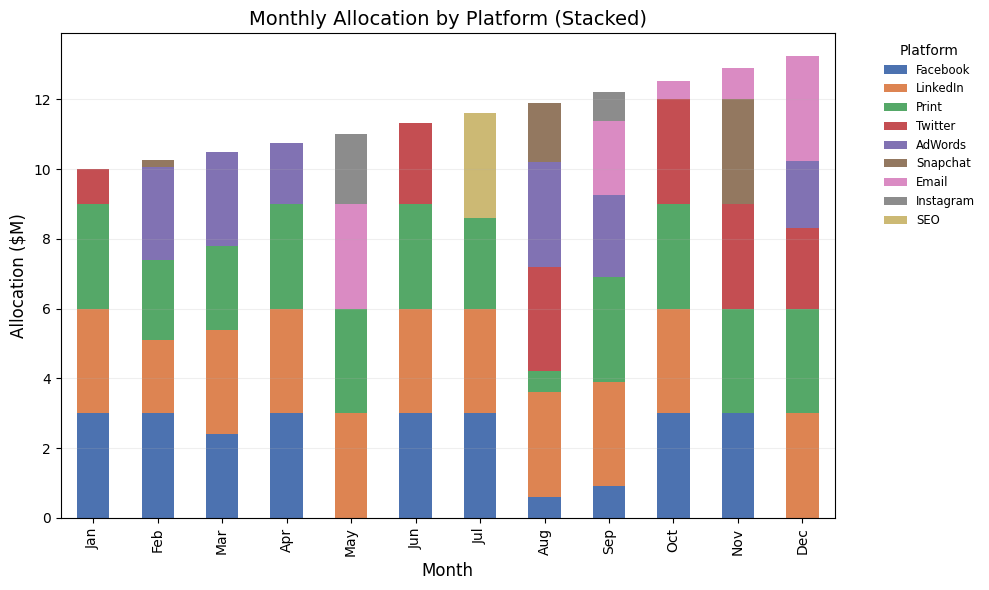

In [ ]:
# Extract monthly data
records = []
for m in rolling_result['monthly_results']:
    row = {'Month': m['month']}
    row.update(m['allocation'])
    records.append(row)

df_alloc = pd.DataFrame(records).fillna(0).set_index('Month')

# Choose a pleasant color palette (widely used)
# Options: 'Set2', 'Paired', 'muted', 'deep', 'pastel'
colors = sns.color_palette("deep", n_colors=len(df_alloc.columns))

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
df_alloc.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)

plt.title("Monthly Allocation by Platform (Stacked)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Allocation ($M)", fontsize=12)
plt.grid(axis='y', alpha=0.2)
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.tight_layout()
plt.show()

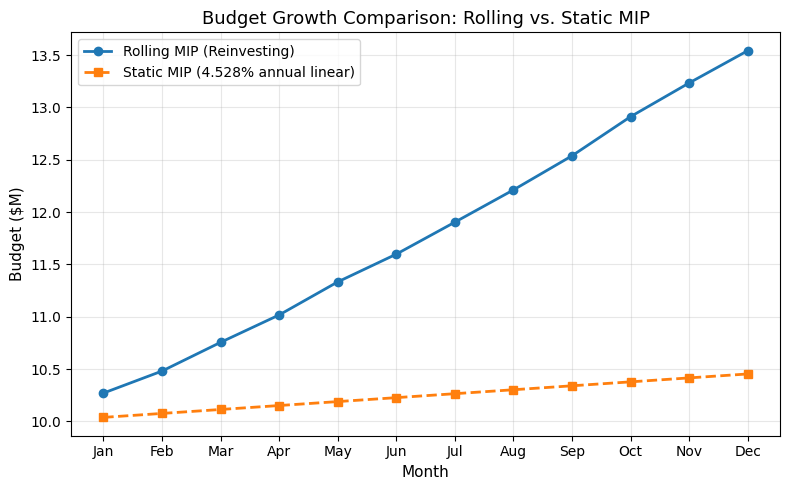

In [92]:
# === Extract data from rolling model ===
months = [r['month'] for r in rolling_result['monthly_results']]
end_budget = [r['budget_next'] for r in rolling_result['monthly_results']]

# === Static MIP (simple linear annual growth of 4.528%) ===
base_budget = 10.0
annual_roi = 0.04528  # 4.528% total over the entire year
final_budget_static = base_budget * (1 + annual_roi)

# Linear interpolation across months (value at END of each month)
simple_mip_line = np.linspace(
    base_budget * (1 + annual_roi / 12),  # end of month 1
    final_budget_static,                  # end of month 12
    len(months)
)

# === Plot ===
plt.figure(figsize=(8,5))
plt.plot(months, end_budget, marker='o', linewidth=2, label="Rolling MIP (Reinvesting)")
plt.plot(months, simple_mip_line, marker='s', linestyle='--', linewidth=2, label="Static MIP (4.528% annual linear)")

plt.title("Budget Growth Comparison: Rolling vs. Static MIP", fontsize=13)
plt.xlabel("Month", fontsize=11)
plt.ylabel("Budget ($M)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

---

## Are the allocations stable?

In [78]:
# Analyze stability of rolling monthly allocations
def analyze_allocation_stability(rolling_result, stability_threshold=1.0):
    """
    Analyze whether monthly allocations are stable (changes ≤ threshold)
    
    Parameters:
    -----------
    rolling_result : dict
        Results from solve_rolling_monthly_model
    stability_threshold : float
        Maximum allowed change in platform spend between months (in millions)
    
    Returns:
    --------
    dict with stability analysis results
    """
    monthly_results = rolling_result['monthly_results']
    
    if len(monthly_results) < 2:
        return {
            'is_stable': True,
            'violations': [],
            'summary': "Need at least 2 months to analyze stability"
        }
    
    violations = []
    all_platforms = set()
    
    # Collect all platforms across all months
    for month_data in monthly_results:
        all_platforms.update(month_data['allocation'].keys())
    
    # Check stability between consecutive months
    for i in range(1, len(monthly_results)):
        prev_month = monthly_results[i-1]
        curr_month = monthly_results[i]
        
        prev_alloc = prev_month['allocation']
        curr_alloc = curr_month['allocation']
        
        for platform in all_platforms:
            prev_spend = prev_alloc.get(platform, 0.0)
            curr_spend = curr_alloc.get(platform, 0.0)
            change = curr_spend - prev_spend
            
            if abs(change) > stability_threshold:
                violations.append({
                    'from_month': prev_month['month'],
                    'to_month': curr_month['month'],
                    'platform': platform,
                    'prev_spend': prev_spend,
                    'curr_spend': curr_spend,
                    'change': change,
                    'violation_amount': abs(change) - stability_threshold
                })
    
    # Summary statistics
    is_stable = len(violations) == 0
    
    if violations:
        max_violation = max(violations, key=lambda x: abs(x['change']))
        platform_violation_counts = {}
        for v in violations:
            platform_violation_counts[v['platform']] = platform_violation_counts.get(v['platform'], 0) + 1
    else:
        max_violation = None
        platform_violation_counts = {}
    
    return {
        'is_stable': is_stable,
        'violations': violations,
        'num_violations': len(violations),
        'max_violation': max_violation,
        'platform_violation_counts': platform_violation_counts,
        'threshold': stability_threshold
    }

In [79]:
# Run stability analysis
stability_analysis = analyze_allocation_stability(rolling_result, stability_threshold=1.0)

# Print results
print("="*70)
print("ALLOCATION STABILITY ANALYSIS")
print("="*70)

if stability_analysis['is_stable']:
    print("\n✓ The allocation is STABLE.")
    print(f"  All month-to-month platform changes are ≤ ${stability_analysis['threshold']}M")
else:
    print("\n✗ The allocation is NOT STABLE.")
    print(f"  Found {stability_analysis['num_violations']} violations of the ${stability_analysis['threshold']}M threshold")
    
    print("\n" + "-"*70)
    print("VIOLATIONS (sorted by magnitude):")
    print("-"*70)
    
    sorted_violations = sorted(stability_analysis['violations'], 
                               key=lambda x: abs(x['change']), 
                               reverse=True)
    
    for v in sorted_violations[:10]:  # Show top 10
        direction = "increased" if v['change'] > 0 else "decreased"
        print(f"\n{v['platform']:10s} ({v['from_month']} → {v['to_month']}):")
        print(f"  {direction} from ${v['prev_spend']:.3f}M to ${v['curr_spend']:.3f}M")
        print(f"  Change: ${v['change']:+.3f}M (violation: ${v['violation_amount']:.3f}M)")
    
    if len(sorted_violations) > 10:
        print(f"\n... and {len(sorted_violations) - 10} more violations")
    
    print("\n" + "-"*70)
    print("PLATFORMS WITH MOST VIOLATIONS:")
    print("-"*70)
    sorted_platforms = sorted(stability_analysis['platform_violation_counts'].items(), 
                              key=lambda x: x[1], 
                              reverse=True)
    for platform, count in sorted_platforms:
        print(f"  {platform:10s}: {count} violation(s)")

ALLOCATION STABILITY ANALYSIS

✗ The allocation is NOT STABLE.
  Found 32 violations of the $1.0M threshold

----------------------------------------------------------------------
VIOLATIONS (sorted by magnitude):
----------------------------------------------------------------------

Facebook   (Apr → May):
  decreased from $3.000M to $0.000M
  Change: $-3.000M (violation: $2.000M)

Email      (Apr → May):
  increased from $0.000M to $3.000M
  Change: $+3.000M (violation: $2.000M)

Facebook   (May → Jun):
  increased from $0.000M to $3.000M
  Change: $+3.000M (violation: $2.000M)

Email      (May → Jun):
  decreased from $3.000M to $0.000M
  Change: $-3.000M (violation: $2.000M)

SEO        (Jun → Jul):
  increased from $0.000M to $3.000M
  Change: $+3.000M (violation: $2.000M)

Twitter    (Jul → Aug):
  increased from $0.000M to $3.000M
  Change: $+3.000M (violation: $2.000M)

AdWords    (Jul → Aug):
  increased from $0.000M to $3.000M
  Change: $+3.000M (violation: $2.000M)

SEO    

In [80]:
# Visualize month-to-month changes
print("\n" + "="*70)
print("MONTH-TO-MONTH PLATFORM ALLOCATION CHANGES")
print("="*70)

monthly_results = rolling_result['monthly_results']
all_platforms = set()
for month_data in monthly_results:
    all_platforms.update(month_data['allocation'].keys())

# Create a table showing allocation changes
print(f"\n{'Platform':<12s}", end='')
for i in range(1, len(monthly_results)):
    transition = f"{monthly_results[i-1]['month']}→{monthly_results[i]['month']}"
    print(f"{transition:^12s}", end='')
print()
print("-" * (12 + 12 * (len(monthly_results) - 1)))

for platform in sorted(all_platforms):
    print(f"{platform:<12s}", end='')
    for i in range(1, len(monthly_results)):
        prev_spend = monthly_results[i-1]['allocation'].get(platform, 0.0)
        curr_spend = monthly_results[i]['allocation'].get(platform, 0.0)
        change = curr_spend - prev_spend
        
        # Color code: show violations in a way that stands out
        if abs(change) > 1.0:
            print(f"{change:+6.2f}**    ", end='')
        else:
            print(f"{change:+6.2f}      ", end='')
    print()

print("\n** indicates violation of stability constraint (|change| > $1M)")


MONTH-TO-MONTH PLATFORM ALLOCATION CHANGES

Platform      Jan→Feb     Feb→Mar     Mar→Apr     Apr→May     May→Jun     Jun→Jul     Jul→Aug     Aug→Sep     Sep→Oct     Oct→Nov     Nov→Dec   
------------------------------------------------------------------------------------------------------------------------------------------------
AdWords      +2.66**     +0.04       -0.94       -1.75**     +0.00       +0.00       +3.00**     -0.63       -2.37**     +0.00       +1.93**    
Email        +0.00       +0.00       +0.00       +3.00**     -3.00**     +0.00       +0.00       +2.10**     -1.56**     +0.37       +2.09**    
Facebook     +0.00       -0.61       +0.61       -3.00**     +3.00**     +0.00       -2.40**     +0.30       +2.10**     +0.00       -3.00**    
Instagram    +0.00       +0.00       +0.00       +2.02**     -2.02**     +0.00       +0.00       +0.84       -0.84       +0.00       +0.00      
LinkedIn     -0.90       +0.90       +0.00       +0.00       +0.00       +0.00       

## Are the allocations stable? (Cont.)

**No.** The allocations from the rolling monthly optimization with reinvestment are **not stable** according to the definition that month-to-month platform spending changes should not exceed $1M.

### Evidence of Instability

The stability analysis (see table above) reveals numerous violations of the $1M threshold. Many platforms experience the maximum possible swing of **±$3M** (hitting the platform cap in one month and zero in the next):

- **Email**: +$3.0M (Apr→May), −$3.0M (May→Jun)
- **Facebook**: −$3.0M (Apr→May), +$3.0M (May→Jun), −$3.0M (Nov→Dec)
- **SEO**: +$3.0M (Jun→Jul), −$3.0M (Jul→Aug)
- **Twitter**: +$3.0M (Jul→Aug), −$3.0M (Aug→Sep), +$3.0M (Sep→Oct)
- **LinkedIn**: −$3.0M (Oct→Nov), +$3.0M (Nov→Dec)
- **Snapchat**: +$3.0M (Oct→Nov), −$3.0M (Nov→Dec)

Other significant violations include AdWords (+$2.66M in Jan→Feb, +$3.0M in Jul→Aug, −$2.37M in Sep→Oct) and Print (−$2.0M in Jul→Aug, +$2.40M in Aug→Sep).

These abrupt changes, often completely entering or exiting platforms month-to-month, create significant operational challenges such as difficulty maintaining consistent campaigns, increased transaction costs from frequent reallocation, and potential disruption to vendor relationships.

---

## Modeling Stability with Hard Constraints

To enforce allocation stability, we need to add constraints that limit month-to-month platform spending changes to ≤$1M. This requires optimizing **all 12 months simultaneously in a single model**, rather than solving each month separately one-at-a-time.

### Mathematical Formulation

**Decision Variables:**
- $x_{i,t}$ = investment in tier $i$ during month $t$ (for all tiers $i$ and months $t = 1, \ldots, 12$)
- $y_{i,t} \in \{0,1\}$ = binary variable indicating whether tier $i$ is active in month $t$

**Platform Spend:**
Let $\mathcal{T}_p$ denote the set of tiers belonging to platform $p$. Define:
$$S_{p,t} = \sum_{i \in \mathcal{T}_p} x_{i,t}$$

This represents the total spend on platform $p$ in month $t$.

**Stability Constraints:**
For each platform $p$ and each month $t = 2, 3, \ldots, 12$:
$$-1 \leq S_{p,t} - S_{p,t-1} \leq 1$$

This can be written as two linear constraints:
$$S_{p,t} - S_{p,t-1} \leq 1$$
$$S_{p,t} - S_{p,t-1} \geq -1$$

**Budget Dynamics:**
The rolling budget must now be modeled as internal constraints:
$$B_1 = 10 \text{ (initial budget in \$M)}$$
$$B_{t+1} = B_t + 0.5 \cdot R_t \quad \text{for } t = 1, \ldots, 11$$

where $R_t = \sum_{i} \text{ROI}_{i,t} \cdot x_{i,t}$ is the total return in month $t$.

**Monthly Budget Constraint:**
$$\sum_{i} x_{i,t} \leq B_t \quad \text{for all } t$$

**Objective:**
$$\max \sum_{t=1}^{12} R_t = \max \sum_{t=1}^{12} \sum_{i} \text{ROI}_{i,t} \cdot x_{i,t}$$

### Expected Trade-offs

Enforcing strict stability will likely:
- **Reduce total 12-month ROI** compared to the unconstrained solution, since we prevent optimal reallocations
- **Smooth the allocation pattern** by limiting dramatic platform entries and exits
- **Increase operational feasibility** by making spending patterns more predictable